In [1]:
import os
import csv  
import pdb
from math import log10, floor
#import itertools
#import zip
from multiprocessing import Pool

import numpy as np
import pandas as pd
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
from scipy.interpolate import RegularGridInterpolator
import scipy.ndimage
#from scipy.misc import logsumexp
from scipy.linalg import cho_factor, cho_solve

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import celerite
import radvel

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [3]:
data = pd.read_csv('../CLSI/legacy_tables/system_props.csv')

In [4]:
specmatch = pd.read_csv('~/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [116]:
objects = pd.read_csv('../CLSI/legacy_tables/planet_list.csv')
trends = pd.read_csv('../CLSI/legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [117]:
objects_real   = objects.query('status != "N" and status != "A" and status != "R"').reset_index(drop=True)
objects_good   = objects_real.query('mass != "nan"').reset_index(drop=True)
planets_s      = objects_good.query('(status == "S" or status == "SS") and mass > 10').reset_index(drop=True)
planets        = objects_good.query('status != "S" and status != "SS" and hostname != "66428"').reset_index(drop=True)
planets_old    = planets.query('status == "K"').reset_index(drop=True)
planets_new    = planets.query('status == "C" or status == "J"').reset_index(drop=True)

In [6]:
planets_s.query('mass_med < 80')

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
2,10,111031,S,1.0,31.859951,65.621611,32.895063,112.452696,21.873947,32.220638,...,0.561592,0.003186,0.001464,0.000676,0.003095,2.722353,3.306287,0.000676,0.003095,/data/user/lrosenth/legacy/final_run/111031/11...
5,30,126614,S,1.0,21.156384,27.635242,22.518464,34.055481,14.920767,16.495014,...,0.063249,0.006477,0.005292,0.004318,0.006521,2.279929,2.398070,0.004318,0.006521,/data/user/lrosenth/legacy/final_run/126614/12...
10,77,16160,S,1.0,66.974357,67.360164,65.801957,68.866319,15.967736,16.368001,...,0.644516,0.001009,0.000959,0.000888,0.001037,3.628854,3.674996,0.000888,0.001037,/data/user/lrosenth/legacy/final_run/16160/161...
13,86,167215,S,2.0,25.032827,24.359442,20.079095,43.316096,8.126147,7.990628,...,0.453338,0.054126,0.055461,0.043289,0.064967,1.340936,1.332790,0.043289,0.064967,/data/user/lrosenth/legacy/final_run/167215/16...
15,102,18445,S,1.0,31.589618,33.738929,29.472635,40.852173,1.208871,1.208903,...,0.718923,0.188941,0.188967,0.168857,0.211208,0.981020,0.980987,0.168857,0.211208,/data/user/lrosenth/legacy/final_run/18445/184...
17,115,190406,S,1.0,66.047509,67.337085,65.341539,69.357562,15.079214,15.542977,...,0.464368,0.005614,0.005280,0.004855,0.005738,2.362864,2.399398,0.004855,0.005738,/data/user/lrosenth/legacy/final_run/190406/19...
18,134,211681,S,1.0,76.095877,76.412121,73.215543,79.677886,7.753882,7.786680,...,0.444673,0.044315,0.043885,0.040046,0.047997,1.409686,1.413128,0.040046,0.047997,/data/user/lrosenth/legacy/final_run/211681/21...
20,161,239960,S,1.0,39.702641,53.740335,41.213418,64.158051,9.696010,15.135417,...,0.665056,0.000151,0.000062,0.000029,0.000137,5.836410,7.293605,0.000029,0.000137,/data/user/lrosenth/legacy/final_run/239960/23...
27,210,4747,S,1.0,48.421554,49.156142,47.546300,50.815651,9.801573,9.844308,...,0.731690,0.004764,0.004718,0.004375,0.005091,2.461858,2.467887,0.004375,0.005091,/data/user/lrosenth/legacy/final_run/4747/4747...
30,224,68017,S,1.0,22.111786,33.788880,27.999495,39.467197,13.234767,21.175386,...,0.472936,0.005041,0.001969,0.001304,0.003161,2.427360,3.070393,0.001304,0.003161,/data/user/lrosenth/legacy/final_run/68017/680...


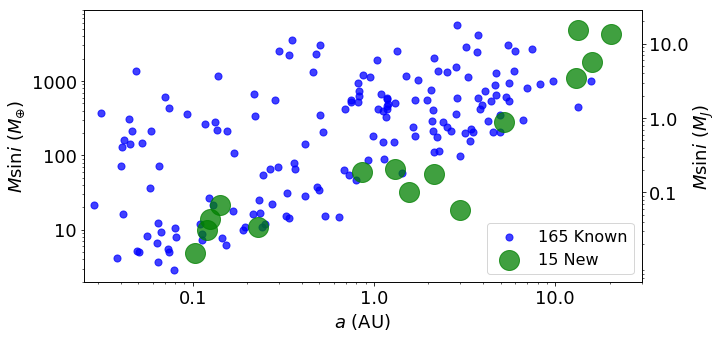

In [11]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_yticks((0.1, 1, 10))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

matplotlib.rcParams.update({'font.size': 18})
ax.scatter(planets_old.axis, 317.8*planets_old.mass, c='b', s=50, alpha=0.75, 
           label='{} Known'.format(len(planets_old)))
ax.scatter(planets_new.axis, 317.8*planets_new.mass, s=400, c='g', alpha=0.75, 
           label='{} New'.format(len(planets_new)))
'''
ax.scatter(planets_old.axis_med, 317.8*planets_old.mass_med, c='b', s=50, alpha=0.75, 
           label='{} Known'.format(len(planets_old)))
ax.scatter(planets_new.axis_med, 317.8*planets_new.mass_med, s=400, c='g', alpha=0.75, 
           label='{} New'.format(len(planets_new)))
'''
ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2, 9000])

ymin, ymax = ax.get_ylim()
ax2.set_ylim((ymin/317.8,ymax/317.8))
ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
#ax.set_xlabel('Semi-major axis (AU)')
ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=4)

#fig.savefig('plots/m_a_scatter.png', dpi=1000, bbox_inches='tight')
#fig.savefig('plots/m_a_scatter.pdf', bbox_inches='tight')

## Pull Specmatch metallicities into planet properties. In 'Masses_good_with_specmatch'.

In [6]:
merge_columns = list(planets.columns)
merge_columns.append('fe')
m_good_spec = pd.DataFrame(columns=merge_columns)

planets['name'] = planets['hostname']
m_good_spec = pd.merge(planets, specmatch, on=['name'])

In [7]:
good_spec_filter = m_good_spec.query('fe > -0.6 and (status == "K" or status == "C")')#axis < 5 and mass > 0.1 
print(len(m_good_spec), len(good_spec_filter))

180 162


In [8]:
len(planets)

180

## Examine mass and period distributions.

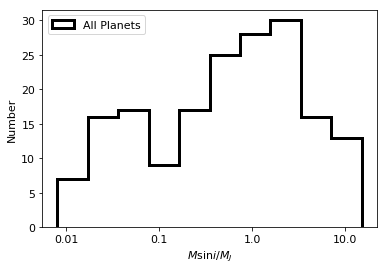

In [42]:
fig, ax = plt.subplots()
ax.hist(np.log10(planets.query('mass < 15')['mass']), 
        bins=10, density=False, histtype='step', range=(np.log10(0.008), np.log10(15)),
        lw=3, color='black', alpha=1, label='All Planets')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i/M_J$', 
          ylabel='Number')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('plots/mass_histogram_all.png', dpi=500, bbox_inches='tight')

In [24]:
masses_close = planets.query('axis < 1 and mass < 15')
masses_mid   = planets.query('axis >= 1 and axis < 3 and mass < 15')
masses_far   = planets.query('axis >= 3 and mass < 15')

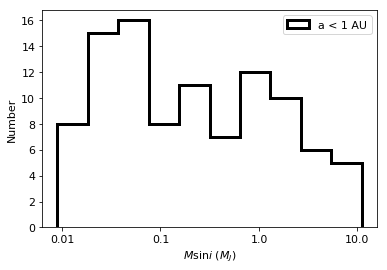

In [25]:
mclose = masses_close.mass
#thresh_close = np.log10(0.075) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mclose), bins=10, density=False, histtype='step',
        lw=3, color='black', alpha=1, label='a < 1 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=1)

fig.savefig('plots/close_histogram.png', dpi=500, bbox_inches='tight')

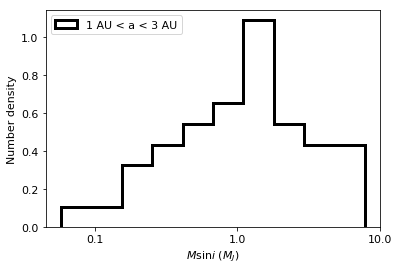

In [26]:
mmid = masses_mid.mass
thresh_mid = np.log10(0.15) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mmid), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='1 AU < a < 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('plots/mid_histogram.png', dpi=500, bbox_inches='tight')

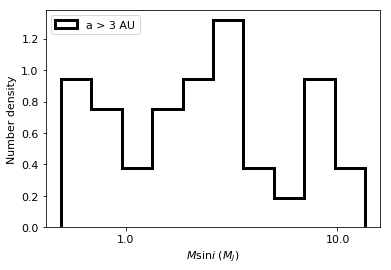

In [27]:
mfar = masses_far.mass
thresh_far = np.log10(1.2) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mfar), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='a > 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)

ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('plots/far_histogram.png', dpi=500, bbox_inches='tight')

## Make distributions of periods and period ratios.

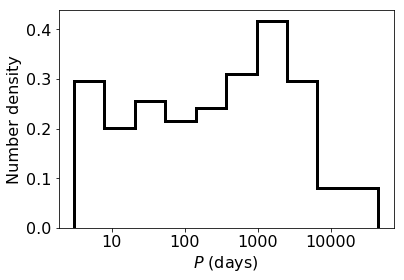

In [48]:
fig, ax = plt.subplots()
ax.hist(np.log10(masses_planet.per), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1)#, label='1 AU < a < 3 AU')

matplotlib.rcParams.update({'font.size': 18})
ax.set(xlabel=r'$P$ (days)', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 18})
        
def format_fn(tick_val, tick_pos):
    #return str(10**tick_val)
    return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 16})
#ax.legend(loc=2)

fig.savefig('planet_candidates/per_histogram.png', dpi=1000)

## Do some preliminary work on giant multis.

In [31]:
planets_big_all   = masses_planet.query('mass > 0.1')
planets_small_all = masses_planet.query('mass <= 0.1')

names_big_all = np.unique(planets_big_all.hostname)
nplanets_big_all = np.array(planets_big_all.groupby('hostname').count()['status'])
db_nplanets_big_all = pd.DataFrame({'hostname':names_big_all, 'nplanets':nplanets_big_all})

names_small_all = np.unique(planets_small_all.hostname)
nplanets_small_all = np.array(planets_small_all.groupby('hostname').count()['status'])
db_nplanets_small_all = pd.DataFrame({'hostname':names_small_all, 'nplanets':nplanets_small_all})

# Do same nplanets thingy for all planets, no mass cuts.
names_all = np.unique(masses_planet.hostname)
nplanets_all = np.array(masses_planet.groupby('hostname').count()['status'])
db_nplanets_all = pd.DataFrame({'hostname':names_all, 'nplanets':nplanets_all})

planets_all       = pd.merge(masses_planet, db_nplanets_all, on='hostname').reset_index()
planets_big_all   = pd.merge(planets_big_all, db_nplanets_big_all, on='hostname').reset_index()
planets_small_all = pd.merge(planets_small_all, db_nplanets_small_all, on='hostname').reset_index()

db_nplanets_all       = None
db_nplanets_big_all   = None
db_nplanets_small_all = None

In [32]:
planets_big_multi_all = planets_big_all.query('nplanets > 1')
planets_multi_all     = planets_all.query('nplanets > 1')

In [35]:
planets_outer = planets_big_multi_all.query('axis > 10')
planets_outer.hostname

1      145675
89      50499
94      66428
132     68988
Name: hostname, dtype: object

In [42]:
prob_outer = len(planets_big_multi_all.query('hostname in @planets_outer.hostname \
                 and axis < 0.1'))/float(len(planets_outer))
sig_outer = np.sqrt(float(len(planets_big_multi_all.query('hostname in @planets_outer.hostname \
                    and axis < 0.1')))) / len(planets_outer)
print(prob_outer, '+\-', sig_outer)

0.25 +\- 0.25


## P(HJ | 10 AU > Outer > 4.64 AU)

In [44]:
planets_med = planets_big_multi_all.query('axis < 10 and axis > 4.64')
planets_med.hostname

15        114783
26        134987
37        156279
51        183263
66        217107
71         24040
83          4203
99         75732
107        92788
121        gl317
123    hip109388
Name: hostname, dtype: object

In [46]:
prob_med = len(planets_big_multi_all.query('hostname in @planets_med.hostname \
               and axis < 0.1'))/float(len(planets_med))
sig_med = np.sqrt(len(planets_big_multi_all.query('hostname in @planets_med.hostname \
                  and axis < 0.1')))/float(len(planets_med))
print(prob_med, '+\-', sig_med)

0.09090909090909091 +\- 0.09090909090909091


## P(HJ | 4.64 AU > Outer > 2.15 AU)

In [47]:
planets_inner = planets_big_multi_all.query('axis < 4.64 and axis > 2.15')
planets_inner.hostname

0         145675
10        108874
20         12661
32        141399
43        168443
46        169830
54        187123
79         38529
88         50499
92         52265
93         66428
96         74156
111        95128
115         9826
122    hip109388
130        37124
Name: hostname, dtype: object

In [48]:
prob_inner = len(planets_big_multi_all.query('hostname in @planets_inner.hostname \
                 and axis < 0.1'))/float(len(planets_med))
sig_inner = np.sqrt(len(planets_big_multi_all.query('hostname in @planets_inner.hostname \
                 and axis < 0.1')))/float(len(planets_med))
print(prob_inner, '+\-', sig_inner)

0.18181818181818182 +\- 0.128564869306645


## How many stars that host small planets have linear or parabolic trends?

In [7]:
trends

,Unnamed: 0,index,hostname,mstar,dvdt,dvdt_med,dvdt_minus,dvdt_plus,curv,curv_med,curv_minus,curv_plus
0,0,2,100623,0.747831,0.004761,0.004752,0.004473,0.005039,NaN,NaN,NaN,NaN
1,1,27,110315,0.718441,-0.055436,-0.055450,-0.055844,-0.055067,0.000002,0.000002,0.000002,0.000002
2,2,28,110537,0.995681,0.019294,0.019365,0.018867,0.019889,NaN,NaN,NaN,NaN
3,3,35,114174,0.968486,0.162774,0.162784,0.162219,0.163379,-0.000002,-0.000003,-0.000003,-0.000002
4,4,41,115404a,0.780834,0.015565,0.015573,0.014551,0.016633,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
84,84,647,151995,0.774024,-0.006613,-0.006426,-0.007244,-0.005525,NaN,NaN,NaN,NaN
85,85,651,156826,1.372675,-0.024066,-0.024204,-0.025148,-0.023406,NaN,NaN,NaN,NaN
86,86,677,180684,1.262973,0.171002,0.170927,0.169106,0.172823,-0.000007,-0.000007,-0.000007,-0.000006
87,87,691,201203,1.459537,-0.144294,-0.144700,-0.154866,-0.135465,-0.000032,-0.000031,-0.000036,-0.000027


In [8]:
trend_names = np.unique(trends.hostname)
small_names = np.unique(planets.query('mass < 0.1 and hostname != "143761"').hostname)

In [9]:
[name for name in trend_names if name in small_names]

['156668', '34445', '45184']

### The 156668 trend is modeling out an activity alias, and the 45184 trend might be activity itself.

## Inner super-Earths and outer gas giants

In [120]:
supers = planets.query('mass < 0.1 and hostname != "143761"').reset_index(drop=True)
# HD 143761 has an inner giant and an outer small planet. Weirdo.
supernames = list(supers.hostname)
print(len(supers), len(np.unique(supers.hostname)))

43 29


In [8]:
outers = planets.query('mass >= 0.1 and hostname in @supernames and hostname != "143761"').reset_index(drop=True)
outernames = list(outers.hostname) # and axis > 0.3

In [9]:
pairs = planets.query('hostname in @outernames').reset_index(drop=True)
solos = planets.query('mass < 0.1 and not (hostname in @outernames)')

In [10]:
pairs.query('mass < 0.1').reset_index()

,index,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
0,1,6,107148,C,2.0,0.067845,0.062633,0.052797,0.072335,0.140652,...,0.401911,67.907955,67.927727,62.685588,73.458712,0.225309,0.225293,62.685588,73.458712,/data/user/lrosenth/legacy/final_run/107148/10...
1,3,22,11964a,K,2.0,0.077996,0.076625,0.070477,0.082858,0.231507,...,0.146884,57.305599,57.252597,52.115983,62.867974,0.235077,0.235131,52.115983,62.867974,/data/user/lrosenth/legacy/final_run/11964a/11...
2,5,73,156668,K,2.0,0.016054,0.015830,0.014511,0.017163,0.050246,...,0.268908,123.266347,123.303176,115.918078,131.067907,0.194110,0.194096,115.918078,131.067907,/data/user/lrosenth/legacy/final_run/156668/15...
3,7,81,164922,K,2.0,0.045698,0.045111,0.041567,0.048725,0.341123,...,0.137637,6.547904,6.548194,6.093519,7.023459,0.404328,0.404324,6.093519,7.023459,/data/user/lrosenth/legacy/final_run/164922/16...
4,8,82,164922,C,3.0,0.034078,0.033118,0.030034,0.036210,0.229199,...,0.123719,14.504370,14.501739,13.494521,15.553995,0.331425,0.331440,13.494521,15.553995,/data/user/lrosenth/legacy/final_run/164922/16...
5,9,83,164922,C,4.0,0.015214,0.014873,0.012801,0.016943,0.102336,...,0.255071,72.755889,72.750376,67.703534,78.033729,0.221459,0.221463,67.703534,78.033729,/data/user/lrosenth/legacy/final_run/164922/16...
6,11,113,190360,K,2.0,0.067746,0.067457,0.064805,0.070118,0.129389,...,0.178086,68.472925,68.446260,63.231229,74.153984,0.224843,0.224865,63.231229,74.153984,/data/user/lrosenth/legacy/final_run/190360/19...
7,13,150,219134,K,2.0,0.052166,0.051641,0.048652,0.054860,0.234586,...,0.104099,5.036966,5.037326,4.713186,5.375092,0.431735,0.431727,4.713186,5.375092,/data/user/lrosenth/legacy/final_run/219134/21...
8,14,151,219134,K,3.0,0.013096,0.012974,0.011896,0.014000,0.038381,...,0.094572,188.168808,188.156135,176.059148,200.770532,0.174632,0.174634,176.059148,200.770532,/data/user/lrosenth/legacy/final_run/219134/21...
9,15,153,219134,K,5.0,0.024599,0.024312,0.022145,0.026595,0.145348,...,0.107707,13.120617,13.120245,12.276311,13.998899,0.339837,0.339840,12.276311,13.998899,/data/user/lrosenth/legacy/final_run/219134/21...


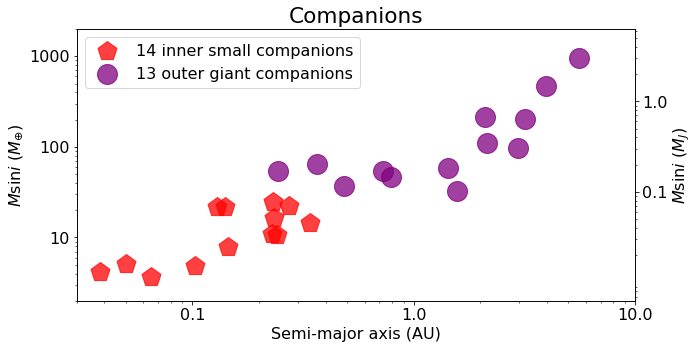

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_yticks((0.1, 1, 10))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Companions')
#ax.scatter(solos.axis, 317.8*solos.mass, c='g', s=400, alpha=0.75, 
#           label='{} solo small planets'.format(len(solos)), marker='d')
ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 10])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()
ax2.set_ylim((ymin/317.8,ymax/317.8))
ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=2)

fig.savefig('plots/earths_and_giants.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/earths_and_giants.pdf', bbox_inches='tight')

In [22]:
pair_outer

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
0,5,107148,K,1.0,0.205914,0.202538,0.187767,0.216985,0.366802,0.366796,...,0.208622,9.985084,9.987654,9.216328,10.800504,0.363849,0.363826,9.216328,10.800504,/data/user/lrosenth/legacy/final_run/107148/10...
1,21,11964a,K,1.0,0.635083,0.630694,0.603547,0.658001,3.185356,3.185235,...,0.122298,0.302698,0.302502,0.275326,0.332116,0.871982,0.872122,0.275326,0.332116,/data/user/lrosenth/legacy/final_run/11964a/11...
2,72,156668,C,1.0,0.101324,0.099085,0.091433,0.106949,1.570776,1.570311,...,0.127107,0.126132,0.126187,0.118565,0.134224,1.085308,1.085191,0.118565,0.134224,/data/user/lrosenth/legacy/final_run/156668/15...
3,80,164922,K,1.0,0.346639,0.344332,0.331411,0.357478,2.148076,2.148672,...,0.077760,0.165129,0.165051,0.153577,0.177032,1.014620,1.014740,0.153577,0.177032,/data/user/lrosenth/legacy/final_run/164922/16...
4,112,190360,K,1.0,1.491530,1.492034,1.449298,1.534622,3.954768,3.955002,...,0.331251,0.073294,0.073273,0.067685,0.079374,1.243060,1.243151,0.067685,0.079374,/data/user/lrosenth/legacy/final_run/190360/19...
5,149,219134,K,1.0,0.308085,0.308135,0.293885,0.322477,2.968637,2.968344,...,0.036888,0.031453,0.031451,0.029399,0.033602,1.535836,1.535856,0.029399,0.033602,/data/user/lrosenth/legacy/final_run/219134/21...
6,181,34445,K,1.0,0.676592,0.657911,0.618128,0.698477,2.105255,2.105131,...,0.131728,0.511203,0.511520,0.470506,0.555787,0.764911,0.764793,0.470506,0.555787,/data/user/lrosenth/legacy/final_run/34445/344...
7,182,34445,K,2.0,0.170994,0.166236,0.144584,0.188548,0.726697,0.726647,...,0.226500,4.290385,4.294080,3.950751,4.664855,0.449402,0.449306,3.950751,4.664855,/data/user/lrosenth/legacy/final_run/34445/344...
8,183,34445,K,3.0,0.116648,0.114355,0.100274,0.129006,0.486691,0.486644,...,0.313639,9.565247,9.573636,8.807664,10.398344,0.367778,0.367697,8.807664,10.398344,/data/user/lrosenth/legacy/final_run/34445/344...
10,238,75732,K,2.0,0.171361,0.170986,0.164405,0.177567,0.243242,0.243244,...,0.063242,11.279593,11.279701,10.405479,12.228171,0.352928,0.352927,10.405479,12.228171,/data/user/lrosenth/legacy/final_run/75732/757...


## Preliminary statistics.

In [118]:
all_outers  = planets.query('mass >= 0.1 and axis > 0.23 and hostname != "143761"')
outernames = list(all_outers.hostname)
inners = planets.query('mass < 0.1 and hostname in @outernames and hostname != "143761"').reset_index(drop=True)

In [12]:
print(len(supers), 'small planets,', len(outers), 'outer companions,', len(outers)/len(supers))

43 small planets, 14 outer companions, 0.32558139534883723


In [13]:
print(len(np.unique(supers.hostname)), 'small planet systems,', len(np.unique(outers.hostname)), 
      'inner and outer systems,', len(np.unique(outers.hostname))/len(np.unique(supers.hostname)))

29 small planet systems, 9 inner and outer systems, 0.3103448275862069


In [14]:
print(len(all_outers), 'cold giants,', len(inners), 'inner companions,', len(inners)/len(all_outers))

113 cold giants, 14 inner companions, 0.12389380530973451


In [15]:
print(len(np.unique(all_outers.hostname)), 'cold giant systems,', len(np.unique(inners.hostname)), 
      'inner and outer systems,', len(np.unique(inners.hostname))/len(np.unique(all_outers.hostname)))

81 cold giant systems, 9 inner and outer systems, 0.1111111111111111


## Compare metallicities of all planet hosts and inner-outer pair hosts.

In [16]:
m_spec_pairs = m_good_spec.query('hostname in @outernames')

NameError: name 'm_good_spec' is not defined

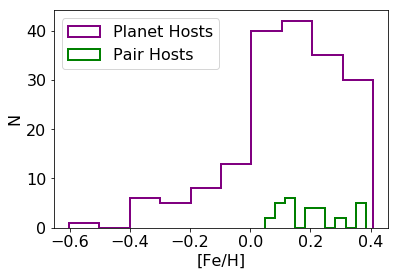

In [58]:
fig, ax = plt.subplots()
ax.hist(m_good_spec.fe_c, density=False, histtype='step', lw=2, color='purple', label='Planet Hosts')
ax.hist(m_spec_pairs.fe_c, density=False, histtype='step', lw=2, color='green', label='Pair Hosts')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('N')
ax.legend(loc=2)
fig.savefig('analysis_plots/pair_fe_histogram.pdf')

In [35]:
planets.query('mass < 0.03')

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path,name
11,17,115617,K,2.0,0.016240,0.016078,0.014473,0.017753,0.049558,0.049563,...,379.065701,378.949258,350.629305,409.144916,0.146582,0.146593,350.629305,409.144916,/data/user/lrosenth/legacy/final_run/115617/11...,115617
24,35,1326,K,1.0,0.017233,0.017080,0.015764,0.018399,0.073202,0.073202,...,4.629984,4.630508,4.402979,4.866417,0.440925,0.440912,4.402979,4.866417,/data/user/lrosenth/legacy/final_run/1326/1326...,1326
40,61,1461,K,1.0,0.020805,0.020755,0.019000,0.022689,0.063605,0.063603,...,309.796966,310.011339,283.998027,337.741704,0.154167,0.154140,283.998027,337.741704,/data/user/lrosenth/legacy/final_run/1461/1461...,1461
41,62,1461,K,2.0,0.022990,0.022244,0.019398,0.025017,0.112105,0.112098,...,99.726198,99.806430,91.428833,108.720831,0.204671,0.204630,91.428833,108.720831,/data/user/lrosenth/legacy/final_run/1461/1461...,1461
47,73,156668,K,2.0,0.016054,0.015830,0.014511,0.017163,0.050246,0.050244,...,123.266347,123.303176,115.918078,131.067907,0.194110,0.194096,115.918078,131.067907,/data/user/lrosenth/legacy/final_run/156668/15...,156668
52,83,164922,C,4.0,0.015214,0.014873,0.012801,0.016943,0.102336,0.102336,...,72.755889,72.750376,67.703534,78.033729,0.221459,0.221463,67.703534,78.033729,/data/user/lrosenth/legacy/final_run/164922/16...,164922
86,151,219134,K,3.0,0.013096,0.012974,0.011896,0.014000,0.038381,0.038375,...,188.168808,188.156135,176.059148,200.770532,0.174632,0.174634,176.059148,200.770532,/data/user/lrosenth/legacy/final_run/219134/21...,219134
87,153,219134,K,5.0,0.024599,0.024312,0.022145,0.026595,0.145348,0.145328,...,13.120617,13.120245,12.276311,13.998899,0.339837,0.339840,12.276311,13.998899,/data/user/lrosenth/legacy/final_run/219134/21...,219134
88,154,219134,K,6.0,0.011640,0.011239,0.009821,0.012608,0.064667,0.064657,...,66.284692,66.284545,62.020037,70.728049,0.226676,0.226676,62.020037,70.728049,/data/user/lrosenth/legacy/final_run/219134/21...,219134
95,172,285968,K,1.0,0.029413,0.028523,0.024196,0.032843,0.066491,0.066490,...,8.730870,8.727840,8.308459,9.168796,0.376266,0.376299,8.308459,9.168796,/data/user/lrosenth/legacy/final_run/285968/28...,285968


## Sketch Occurrence algorithms. ABC first.

In [49]:
class Alphabetizer(object):
    """Do ABC sampling.
    Args:
        whatever (whatever): whatever

    """
    def __init__(self, rpop, starnames, completeness, nparts=20, upper=1,
                 amin=1, amax=10, mmin=0.1, mmax=1):
        # TO-DO: Replace single-param planets with paths to posteriors.
        self.rpop         = rpop 
        self.starnames    = starnames
        self.nstars       = len(starnames)
        self.fobs         = len(rpop)/nstars
        self.completeness = completeness
        self.nparts       = int(nparts)
        self.upper        = upper
        self.amin         = amin
        self.amax         = amax
        self.mmin         = mmin
        self.mmax         = mmax        
        self.spops        = []
        self.all_draws    = []
        self.final_sample = []
 
    def normal(self, x, mu, sigma):
        return np.exp((x - mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma) 

    def populate(self, fp):
        spop = []
        #for name in starnames:
        for i in np.arange(self.nstars):
            # Decide whether to populate with a planet
            if np.random.uniform() <= fp:
                planet = {}
                planet['star'] = name
                planet['mass'] = 10**np.uniform.random(-2.1, -1.)
                planet['axis'] = 10**np.uniform.random(-1.52, 0.)
                planet['sini'] = np.sin(np.arccos(np.random.uniform(-0.99, 0.99))) # Necessary?               
                
    def observe(self, a, m):
        # Determine which planets are observed and which aren't, using completeness.
        # Return observed catalog?
        if np.random.uniform() < completeness(np.log(a), np.log(m)):
            return True
        else:
            return False
        
    def distance(self, fp):
        return (self.fobs - fp)**2
    
    def importance(self, weights, samples, covar):
        # Draw from the importance sampling distribution.
        choice = np.random.choice(len(weights), p=weights) 
        return np.random.normal(samples[choice], 2*covar)

    def sample(self, fp):
        ''' In each generation, draw samples until there are N
        that meet the distance criterion. Reweight sampling, and 
        draw again, with tighter distance criterion. Repeat until
        change with tighter citerion is negligible, then draw 
        samples from the final distribution until desired
        number of samples pass final distance criterion.
        '''
        
        # Perform initial sampling. Draw from uniform prior.
         # Sample covariance? Maybe just variance for 1D?
        eps = 0.0625 # Initial distance criterion, 0.25**2
        draws = []
        while len(draws) < self.nparts:
            draw = np.random.uniform(0, self.upper)
            # Generate synthetic population based on the drawn occurrence rate.
            sobs = ?
            if distance(sobs) < eps:
                draws.append(draw)
        
        # Initialize weights, ratio of prior values to importance values.    
        weights = np.ones(self.nparts)/self.nparts 
        # Initialize accepted samples for the next generation.
        samples = draws
        
        # Proceed with generative sampling.
        for i in np.arange(200):
            covar = np.var(samples)
            draws = []
            while len(draws) < self.nparts:
                draw = self.importance(weights, samples, covar)
                sobs = ?
                if distance(sobs) < eps:
                    draws.append(draw)                
                   
            # Update weights, with uniform prior.     
            weights = 1/np.sum(weights*self.normal(draws, samples, 2*covar))
            weights /= np.sum(weights)
            samples = draws
            eps /= 4
        
        pass

SyntaxError: invalid syntax (<ipython-input-49-e3285d66f8ad>, line 66)

## Sketch DFM occurrence likelihood model.

In [98]:
class Hierarchy(object):
    """Do hierarchical Bayesian sampling of occurrence posteriors, based on DFM et al. 2014.
    Args:
        pop (pandas DataFrame): dataframe of planet parameter chains

    """
    def __init__(self, pop, completeness, res=4, bins=np.array([[[np.log(0.02), np.log(20)], 
                                                                 [np.log(2.), np.log(6000)]]])):
        # TO-DO: Replace single-param planets with paths to posteriors.
        self.pop          = pop # Replace pairs of m & a with chains
        self.completeness = completeness # Completeness grid, defined as class object below.
        self.completeness.completeness_grid([0.01, 40], [1, 30000])
        self.res = res # Resolution for logarithmic completeness integration.
        self.bins = bins # Logarithmic bins in msini/axis space.
        self.nbins = len(self.bins)
        self.lna_edges = np.unique(self.bins[:, 0])
        self.lnm_edges = np.unique(self.bins[:, 1])
        self.nabins = len(self.lna_edges) - 1
        self.nmbins = len(self.lnm_edges) - 1
        self.na = len(self.lna_edges)
        self.nm = len(self.lnm_edges)
        
        # Compute bin centers and widths.
        self.bin_widths  = np.diff(self.bins)
        self.bin_centers = np.mean(self.bins, axis=2)
        self.bin_areas   = self.bin_widths[:,0]*self.bin_widths[:,1]
        
        # Pre-compute integrated completeness for each bin.
        self.Qints = np.zeros(self.nbins)
        for n, binn in enumerate(self.bins):
            for i in np.arange(4): #self.res
                for j in np.arange(4):
                    #lna1 = binn[0][0] + 0.25*i*(binn[0][1] - binn[0][0])
                    #lnm1 = binn[1][0] + 0.25*j*(binn[0][1] - binn[1][0])
                    lna_av = binn[0][0] + (0.25*i + 0.125)*(binn[0][1] - binn[0][0])
                    lnm_av = binn[1][0] + (0.25*j + 0.125)*(binn[1][1] - binn[1][0])
                    self.Qints[n] += (self.bin_areas[n][0]/self.res**2)*self.completeness.interpolate(
                                                                          np.exp(lna_av), 
                                                                          np.exp(lnm_av))
                
        axis  = []
        msini = []
        self.planetnames = np.unique([x[:-2] + x[-1] for x in pop.columns]) 
        self.starnames   = np.unique([x[:-1] for x in self.planetnames])
        self.nplanets    = len(self.planetnames)
        self.nsamples    = len(self.pop)
        self.nstars      = len(self.starnames)
        
        medians = pop.median() # Along chain axis, once using chains.
        for name in self.planetnames:
            axis.append(medians[[name[:-1] + 'a' + name[-1]]][0])
            msini.append(medians[[name[:-1] + 'M' + name[-1]]][0])            
        self.pop_med = pd.DataFrame.from_dict({'axis':axis, 'msini':msini})
        
    def max_like(self):
        ### Approximate max-likelihood occurrence values, with which to seed MCMC.
        mlvalues = np.empty((0,2))
        for n, binn in enumerate(self.bins):
            # Integrate completeness across each individual bin.
            a1 = np.exp(binn[0][0])
            a2 = np.exp(binn[0][1])
            M1 = np.exp(binn[1][0])
            M2 = np.exp(binn[1][1])
            planets = self.pop_med.query('axis >= @a1 and axis < @a2 and \
                                         msini >= @M1 and msini < @M2')
            nplanets = len(planets)
            ml  = nplanets/self.Qints[n]
            uml = ml/np.sqrt(nplanets)
            if not np.isfinite(uml):
                uml = 1.
            mlvalues = np.append(mlvalues, np.array([[ml, uml]]), axis=0) 
        self.mlvalues = mlvalues
        
    def occurrence(self, lna, lnm, theta):
        # Select appropriate bins, given lna & lnm.
        ia = np.atleast_1d(np.digitize(lna, self.lna_edges) - 1)
        im = np.atleast_1d(np.digitize(lnm, self.lnm_edges) - 1)
        iao = ia
        imo = im
        ia[ia < 0] = 0
        im[im < 0] = 0
        ia[ia > self.nabins - 1] = self.nabins - 1
        im[im > self.nmbins - 1] = self.nmbins - 1
        
        occur = theta[ia + im*len(self.lna_edges)]
        # Return zero for samples outside of the bin limits.
        occur[iao < 0] = 0
        occur[imo < 0] = 0
        occur[iao > self.nabins - 1] = 0
        occur[imo > self.nmbins - 1] = 0
        return occur    

    def lnlike(self, theta): 
        sums = []
        for planet in self.planetnames:
            #print(planet)
            probs = []
            sample_a = np.array(self.pop[planet[:-2] + '_a' + planet[-1]])
            sample_M = np.array(self.pop[planet[:-2] + '_M' + planet[-1]])
            probs = self.completeness.interpolate(sample_a, sample_M)*self.occurrence(
                                           np.log(sample_a), np.log(sample_M), theta)
            sums.append(np.sum(probs))
        
        # Integrate the observed occurrence over all bins.
        nexpect = 0
        for i, binn in enumerate(self.bins):
            for j in np.arange(4): 
                for k in np.arange(4):
                    lna_av = binn[0][0] + (0.25*j + 0.125)*(binn[0][1] - binn[0][0])
                    lnm_av = binn[1][0] + (0.25*k + 0.125)*(binn[1][1] - binn[1][0])                    
                    nexpect += (self.bin_areas[i][0]/self.res**2)*self.completeness.interpolate(
                                                                        np.exp(lna_av), 
                                                                        np.exp(lnm_av))*self.occurrence(
                                                                        lna_av, 
                                                                        lnm_av, theta)               
        return -nexpect + np.sum(np.log(np.array(sums)/self.nsamples))
    
    def gpprior(self, mu, l0, la, lm, theta):
        ### Prior on occurrence. Gaussian process, for smoothly changing bin heights.
        if not -20 < mu < 20:
            return -np.inf
        if not -2 < l0 < 8:
            return -np.inf
        if not -2 < la < 8:
            return -np.inf
        if not -2 < lm < 8:
            return -np.inf
        if np.any(theta < 0): # + (theta > 50)):
            return -np.inf

        # Compute Euclidean distance between bins, [∆i − ∆j]T Σ−1[∆i − ∆j]
        mini_inv_covar = np.array([[np.exp(la)**-1, 0], [0, np.exp(lm)**-1]])
        X              = np.matmul(mini_inv_covar, self.bin_centers)
        distance       = scipy.spatial.distance.cdist(X, X, 'sqeuclidean')
        
        K        = np.exp(l0)**2*np.exp(-distance)
        s, logdK = np.linalg.slogdet(K)
        
        y  = theta - mu
        F  = cho_factor(K)
        lp = -0.5*(logdK + np.dot(y, cho_solve(F, y)))
        
        if not np.isfinite(lp):
            return -np.inf
        return lp
    
    def lnprior(self, theta):
        if np.any(theta < 0):
            return -np.inf
        else:
            return 0
    
    def lnpost(self, theta):
        return self.lnlike(theta) + self.lnprior(theta) # Leave out GP for now
    
    def sample(self, gp=False):
        nwalkers = 10*len(theta)
        ndim = len(self.bins) #+ 4 # number of prior GP hyperparameters
        mu_init = np.mean(self.mlvalues[:, 0])
        l0_init = 1
        la_init = 1
        lm_init = 1
        pos = [self.mlvalues[:, 0] + 0.01*np.random.randn(ndim) for i in np.arange(nwalkers)]

        #with Pool() as pool:
        self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnpost)#, pool=pool)
        self.sampler.run_mcmc(pos, 1000, progress=True)
        self.chains = self.sampler.chain[:, 50:, :].reshape((-1, ndim))
    
    def run(self):
        self.max_like()
        self.sample()                       

In [27]:
def lngrid(min_a, max_a, min_M, max_M, resa, resm):
    lna1 = np.log(min_a)
    lna2 = np.log(max_a)
    lnM1 = np.log(min_M)
    lnM2 = np.log(max_M)
    
    da = (lna2 - lna1)/resa
    dM = (lnM2 - lnM1)/resm

    bins = []
    for i in np.arange(int(resa)):
        for j in np.arange(int(resm)):
            bins.append([[lna1 + i*da, lna1 + (i+1)*da], 
                         [lnM1 + j*dM, lnM1 + (j+1)*dM]])
            
    return np.array(bins)

In [31]:
grid = [np.log(0.02), np.log(20)], [np.log(2.), np.log(6000)]
test_grid = lngrid(0.02, 20, 2, 6000, 1, 1)
print(grid)
print(test_grid)
#print(np.mean(test_grid, axis=2))

([-3.912023005428146, 2.995732273553991], [0.6931471805599453, 8.699514748210191])
[[[-3.91202301  2.99573227]
  [ 0.69314718  8.69951475]]]


## Sketch code to stack injections on cadence, with msini & a.

In [149]:
def save_completeness(listf, outf, stellarf, recdir):
    names = pd.read_csv(listf)
    stars = pd.read_csv(stellarf)
    
    all_recoveries = pd.DataFrame()
    
    for name in names['name']:
        recoveries = pd.read_csv(recdir + '/' + name + '/recoveries.csv')
        mstar = float(stars.query('name == @name')['mass_c'])
        
        recoveries['inj_msini'] = radvel.utils.Msini(recoveries['inj_k'],
                                                     recoveries['inj_period'],
                                                     mstar, recoveries['inj_e'],
                                                     Msini_units='jupiter')
        recoveries['rec_msini'] = radvel.utils.Msini(recoveries['rec_k'],
                                                     recoveries['rec_period'],
                                                     mstar, recoveries['rec_e'],
                                                     Msini_units='jupiter')
        recoveries['inj_au'] = radvel.utils.semi_major_axis(recoveries['inj_period'], mstar)
        recoveries['rec_au'] = radvel.utils.semi_major_axis(recoveries['rec_period'], mstar)    
        
        all_recoveries = all_recoveries.append(recoveries).reset_index(drop=True)
        
    all_recoveries.to_csv(outf)

## Create class for evaluating a completeness grid across injections and recoveries. Clone of BJ's code in RVSearch, except passing in msini and axis as inputs, rather than computing with a single stellar mass.

In [67]:
class Completeness(object):
    """Object to handle a suite of injection/recovery tests

    Args:
        recoveries (DataFrame): DataFrame of injection/recovery tests from Injections class
        xcol (string): (optional) column name for independent variable. Completeness grids and
            interpolator will work in these axes
        ycol (string): (optional) column name for dependent variable. Completeness grids and
            interpolator will work in these axes

    """   
    def __init__(self, recoveries, xcol='inj_au', ycol='inj_msini'):

        self.recoveries = recoveries
        
        self.xcol = xcol
        self.ycol = ycol

        self.grid = None
        self.interpolator = None    

    def completeness_grid(self, xlim, ylim, resolution=50, xlogwin=0.5, ylogwin=0.5):

        xgrid = np.logspace(np.log10(xlim[0]),
                            np.log10(xlim[1]),
                            resolution)
        ygrid = np.logspace(np.log10(ylim[0]),
                            np.log10(ylim[1]),
                            resolution)

        xinj = self.recoveries[self.xcol]
        yinj = self.recoveries[self.ycol]

        good = self.recoveries['recovered']
        
        z = np.zeros((len(ygrid), len(xgrid)))
        last = 0
        for i,x in enumerate(xgrid):
            for j,y in enumerate(ygrid):
                xlow  = 10**(np.log10(x) - xlogwin/2)
                xhigh = 10**(np.log10(x) + xlogwin/2)
                ylow  = 10**(np.log10(y) - ylogwin/2)
                yhigh = 10**(np.log10(y) + ylogwin/2)

                xbox = yinj[np.where((xinj <= xhigh) & (xinj >= xlow))[0]]
                if len(xbox) == 0 or y > max(xbox) or y < min(xbox):
                    z[j, i] = np.nan
                    continue

                boxall = np.where((xinj <= xhigh) & (xinj >= xlow) &
                                  (yinj <= yhigh) & (yinj >= ylow))[0]
                boxgood = np.where((xinj[good] <= xhigh) &
                                   (xinj[good] >= xlow) & (yinj[good] <= yhigh) &
                                   (yinj[good] >= ylow))[0]

                if len(boxall) > 10:
                    z[j, i] = float(len(boxgood))/len(boxall)
                    last = float(len(boxgood))/len(boxall)
                else:
                    z[j, i] = np.nan

        self.grid = (xgrid, ygrid, z)
    
    def interpolate(self, x, y, refresh=False):

        if self.interpolator is None or refresh:
            assert self.grid is not None, "Must run Completeness.completeness_grid()."
            zi = self.grid[2].T
            self.interpolator = RegularGridInterpolator((self.grid[0], self.grid[1]), zi, 
                                                        bounds_error=False, fill_value=0.01) # Maybe don't set fill
        
        return self.interpolator(np.array([np.atleast_1d(x), np.atleast_1d(y)]).T)

In [68]:
recoveries_all = pd.read_csv('recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)

In [20]:
completey_all.completeness_grid([0.01, 40], [1, 30000])

In [22]:
completey_all.interpolate(np.arange(1, 5), np.arange(10, 14))

array([0.01220107, 0.00457318, 0.00258574, 0.00153472])

In [60]:
samples_all = pd.read_csv('../samples_all_1000.csv').sample(50).reset_index(drop=True)
good_cols = [col for col in samples_all.columns if '_a' in col or '_M' in col]
for col in good_cols:
    if '_M' in col:
        samples_all[col] *= 317.8

In [61]:
samples_all

,Unnamed: 0,104067_e1,104067_a1,104067_M1,104067_k1,104067_per1,10697_e1,10697_a1,10697_M1,10697_k1,...,gl876_e1,gl876_a1,gl876_M1,gl876_k1,gl876_per1,gl876_e2,gl876_a2,gl876_M2,gl876_k2,gl876_per2
0,784,0.354856,0.265319,66.650475,13.855012,55.853421,0.108018,2.151254,2038.168079,116.698748,...,0.001385,0.217035,666.640303,211.585238,61.036203,0.003253,0.135857,221.532406,88.870360,30.228425
1,955,0.289965,0.260092,55.468946,11.726041,55.874874,0.099506,2.160442,2036.130264,115.424564,...,0.001696,0.214371,652.585376,212.299503,61.034743,0.008124,0.134194,215.951830,88.796940,30.229421
2,800,0.255175,0.272076,62.212848,11.886956,55.832185,0.093892,2.173784,2074.313596,116.042611,...,0.004170,0.218469,676.553057,211.918607,61.034958,0.010247,0.136757,222.821269,88.219181,30.228617
3,900,0.070840,0.266817,63.416036,12.216754,55.850405,0.087043,2.153737,2027.930203,115.569037,...,0.000750,0.215586,657.527279,211.506130,61.035869,0.001565,0.134953,218.207580,88.715294,30.229289
4,872,0.085116,0.264345,59.932274,11.774048,55.842348,0.092510,2.195451,2094.649784,115.023113,...,0.004416,0.218496,676.396516,211.813714,61.033597,0.000486,0.136777,221.164829,87.534734,30.228842
5,629,0.205208,0.266285,72.435051,14.268397,55.810013,0.099054,2.155220,2037.085671,116.042181,...,0.001354,0.213556,647.323277,212.205859,61.036980,0.004273,0.133680,211.397830,87.591786,30.228988
6,366,0.285349,0.265574,62.246703,12.584325,55.792722,0.102934,2.121477,1929.343799,113.462774,...,0.003939,0.218743,679.424140,212.285648,61.035053,0.007496,0.136928,224.096371,88.500154,30.228541
7,42,0.300129,0.268586,69.001582,13.719487,55.857374,0.103256,2.138688,2006.954890,116.296042,...,0.002574,0.218831,678.399739,211.785528,61.032545,0.008996,0.136990,222.168987,87.663936,30.229372
8,147,0.188083,0.268560,65.785395,12.698963,55.825656,0.112584,2.166497,2040.900164,115.324916,...,0.002515,0.217073,672.634866,213.406125,61.033792,0.014510,0.135887,221.172319,88.698532,30.229360
9,213,0.306459,0.261655,68.842671,14.438596,55.800980,0.096984,2.175860,2098.739312,117.293807,...,0.001120,0.214299,649.212287,211.338563,61.033396,0.011462,0.134151,215.590128,88.708012,30.229185


In [21]:
len(good_cols)

364

In [99]:
hierarchical = Hierarchy(samples_all[good_cols], completey_all)

In [100]:
hierarchical.max_like()

In [101]:
hierarchical.mlvalues

array([[6.79851363, 0.50957014]])

In [102]:
hierarchical.sample()

call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call


call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call


call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call


call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call


call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call


call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call


call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call
call


In [104]:
print(np.median(hierarchical.chains), np.std(hierarchical.chains))

6.932852659380194 0.511400390771193


In [107]:
len(hierarchical.chains)

9500

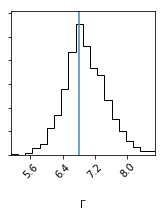

In [110]:
fig = corner.corner(hierarchical.chains[1000:], labels=[r'$\Gamma$'],
                      truths=[hierarchical.mlvalues[0, 0]])

In [98]:
area  = hierarchical.bin_areas[0][0]
total = area * np.exp(hierarchical.mlvalues[0][1])
error = total * hierarchical.mlvalues[0][2]

print('Total expected planets:', total, '+/-', error)
print('Bin-wide planets per star:', total/hierarchical.nstars, '+/-', error/hierarchical.nstars)

## Load completeness and plot with planets.

In [269]:
recoveries_pairs = pd.read_csv('recoveries_small_and_outer_earth.csv')#.sample(100000).reset_index(drop=True)
completey_pairs  = Completeness(recoveries_pairs)
completey_pairs.completeness_grid([0.01, 30], [1, 30000])

In [111]:
recoveries_small = pd.read_csv('recoveries_small_earth.csv')
completey_small  = Completeness(recoveries_small)

In [226]:
recoveries_outer = pd.read_csv('recoveries_outer_earth.csv')
completey_outer  = Completeness(recoveries_outer)

In [227]:
recoveries_planets = pd.read_csv('recoveries_planets_earth.csv')
completey_planets  = Completeness(recoveries_planets)

In [228]:
recoveries_all = pd.read_csv('recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)

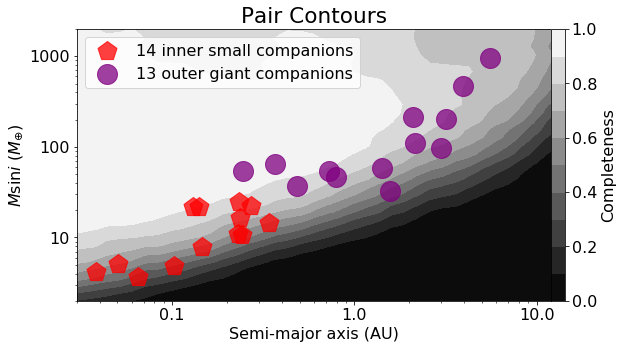

In [210]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_yticks((0.1, 1, 10))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''
CS = ax.contourf(completey_pairs.grid[0], completey_pairs.grid[1],
                 completey_pairs.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Pair Contours')
#ax.scatter(solos.axis, 317.8*solos.mass, c='g', s=400, alpha=0.75, 
#           label='{} solo small planets'.format(len(solos)), marker='d')
ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 12])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/pair_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/pair_contours.pdf', bbox_inches='tight')

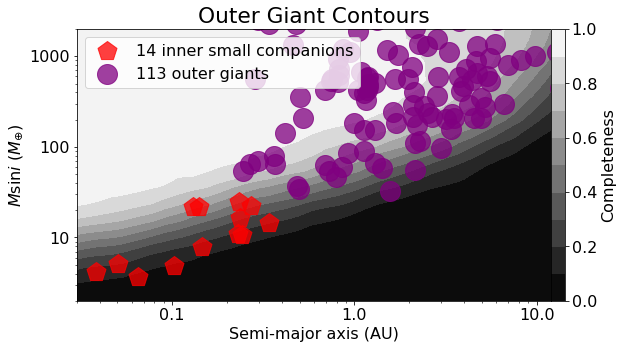

In [272]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_outer.grid[0], completey_outer.grid[1],
                 completey_outer.grid[2], 10, cmap=plt.cm.gray)

pair_outer = all_outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Outer Giant Contours')

ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giants'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 12])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/pair_all_outers.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/pair_all_outers.pdf', bbox_inches='tight')

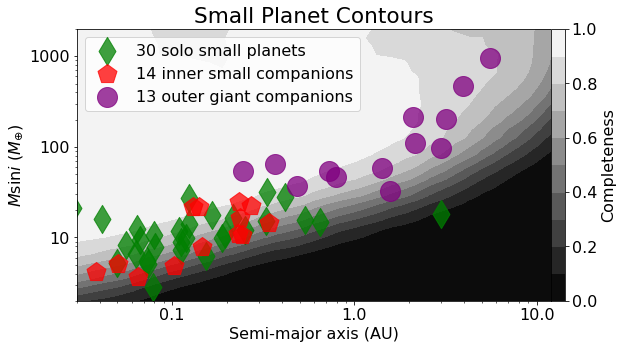

In [211]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_yticks((0.1, 1, 10))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''
CS = ax.contourf(completey_small.grid[0], completey_small.grid[1],
                 completey_small.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Small Planet Contours')
ax.scatter(solos.axis, 317.8*solos.mass, c='g', s=400, alpha=0.75, 
           label='{} solo small planets'.format(len(solos)), marker='d')
ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 12])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/small_planet_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/small_planet_contours.pdf', bbox_inches='tight')

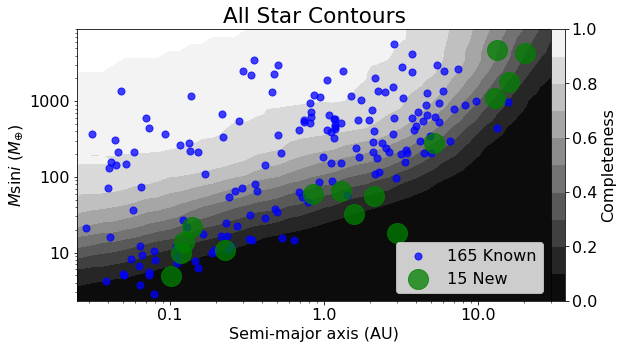

In [226]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_yticks((0.1, 1, 10))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''
CS = ax.contourf(completey_all.grid[0], completey_all.grid[1],
                 completey_all.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('All Star Contours')
ax.scatter(planets_old.axis, 317.8*planets_old.mass, c='b', s=50, alpha=0.75, 
           label='{} Known'.format(len(planets_old)))
ax.scatter(planets_new.axis, 317.8*planets_new.mass, s=400, c='g', alpha=0.75, 
           label='{} New'.format(len(planets_new)))

#ax.set_xlim([3*10**-2, 12])
#ax.set_ylim([2, 2000])
ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2.3, 9000])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=4)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/all_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/all_contours.pdf', bbox_inches='tight')

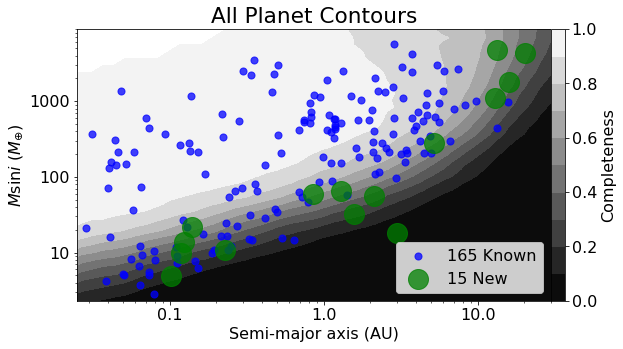

In [228]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_yticks((0.1, 1, 10))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''
CS = ax.contourf(completey_planets.grid[0], completey_planets.grid[1],
                 completey_planets.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('All Planet Contours')
ax.scatter(planets_old.axis, 317.8*planets_old.mass, c='b', s=50, alpha=0.75, 
           label='{} Known'.format(len(planets_old)))
ax.scatter(planets_new.axis, 317.8*planets_new.mass, s=400, c='g', alpha=0.75, 
           label='{} New'.format(len(planets_new)))

#ax.set_xlim([3*10**-2, 12])
#ax.set_ylim([2, 2000])
ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2.3, 9000])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=4)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/all_planet_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/all_planet_contours.pdf', bbox_inches='tight')

## Make sampling dataframes for planet subsets.

In [121]:
samples_all = pd.read_csv('../samples_all_1000.csv')
samples_med = samples_all.median()

columns_small = [col for col in samples_all.columns if col[:-3] in list(all_outers.hostname) \
                 and ('_M' in col or '_a' in col)]
columns_outers = [col for col in samples_all.columns if col[:-3] in list(supers.hostname) \
                 and ('_M' in col or '_a' in col)]

samples_small = samples_all[columns_small]
for col in columns_small:
    if '_M' in col:
        samples_small[col] *= 317.8
        
samples_outers = samples_all[columns_outers]
for col in columns_outers:
    if '_M' in col:
        samples_outers[col] *= 317.8

In [122]:
#hierarchical_outer = Hierarchy(samples_outers, completey_small, 
#                               bins=np.array([[[np.log(0.2), np.log(30.)], 
#                                               [np.log(30.), np.log(317.8*20)]]]))
outerbins = lngrid(0.2, 30., 30., 317.8*20, 5, 4) #min_a, max_a, min_M, max_M, resa, resm
hierarchical_outer = Hierarchy(samples_outers, completey_small, bins=outerbins)

In [123]:
hierarchical_outer.max_like()

In [124]:
hierarchical_outer.mlvalues

array([[3.15759922, 1.57879961],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [2.59402896, 1.49766332],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [3.64471016, 2.10427439],
       [1.73867103, 1.22942608],
       [0.87005818, 0.87005818],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.99011519, 0.99011519],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [126]:
hierarchical_outer.sample()

ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

In [233]:
nsuperstars = len(np.unique(supers.hostname))
nouterstars = len(np.unique(planets.query('axis > 0.23 and mass >= 0.1').hostname))

In [237]:
outers

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
0,5,107148,K,1.0,0.205914,0.202538,0.187767,0.216985,0.366802,0.366796,...,0.208622,9.985084,9.987654,9.216328,10.800504,0.363849,0.363826,9.216328,10.800504,/data/user/lrosenth/legacy/final_run/107148/10...
1,21,11964a,K,1.0,0.635083,0.630694,0.603547,0.658001,3.185356,3.185235,...,0.122298,0.302698,0.302502,0.275326,0.332116,0.871982,0.872122,0.275326,0.332116,/data/user/lrosenth/legacy/final_run/11964a/11...
2,72,156668,C,1.0,0.101324,0.099085,0.091433,0.106949,1.570776,1.570311,...,0.127107,0.126132,0.126187,0.118565,0.134224,1.085308,1.085191,0.118565,0.134224,/data/user/lrosenth/legacy/final_run/156668/15...
3,80,164922,K,1.0,0.346639,0.344332,0.331411,0.357478,2.148076,2.148672,...,0.077760,0.165129,0.165051,0.153577,0.177032,1.014620,1.014740,0.153577,0.177032,/data/user/lrosenth/legacy/final_run/164922/16...
4,112,190360,K,1.0,1.491530,1.492034,1.449298,1.534622,3.954768,3.955002,...,0.331251,0.073294,0.073273,0.067685,0.079374,1.243060,1.243151,0.067685,0.079374,/data/user/lrosenth/legacy/final_run/190360/19...
5,149,219134,K,1.0,0.308085,0.308135,0.293885,0.322477,2.968637,2.968344,...,0.036888,0.031453,0.031451,0.029399,0.033602,1.535836,1.535856,0.029399,0.033602,/data/user/lrosenth/legacy/final_run/219134/21...
6,181,34445,K,1.0,0.676592,0.657911,0.618128,0.698477,2.105255,2.105131,...,0.131728,0.511203,0.511520,0.470506,0.555787,0.764911,0.764793,0.470506,0.555787,/data/user/lrosenth/legacy/final_run/34445/344...
7,182,34445,K,2.0,0.170994,0.166236,0.144584,0.188548,0.726697,0.726647,...,0.226500,4.290385,4.294080,3.950751,4.664855,0.449402,0.449306,3.950751,4.664855,/data/user/lrosenth/legacy/final_run/34445/344...
8,183,34445,K,3.0,0.116648,0.114355,0.100274,0.129006,0.486691,0.486644,...,0.313639,9.565247,9.573636,8.807664,10.398344,0.367778,0.367697,8.807664,10.398344,/data/user/lrosenth/legacy/final_run/34445/344...
9,237,75732,K,1.0,0.841438,0.841337,0.815357,0.867360,0.116185,0.116188,...,0.006538,49.438951,49.437459,45.606729,53.593902,0.243917,0.243919,45.606729,53.593902,/data/user/lrosenth/legacy/final_run/75732/757...


In [239]:
area  = hierarchical_outer.bin_areas[0][0]
rates = area * np.exp(hierarchical_outer.mlvalues[:, 0])
total = np.sum(rates)
error = np.sum(total * hierarchical_outer.mlvalues[:, 1])

print('Total expected planets:', total, '+/-', error)
print('Bin-wide planets per star:', total/nsuperstars/(2), '+/-', error/nsuperstars)

Total expected planets: 22.865293734669095 +/- inf
Bin-wide planets per star: 0.39422920232188097 +/- inf


In [261]:
hierarchical_inner = Hierarchy(samples_small, completey_outer, 
                               bins=np.array([[[np.log(0.023), np.log(1)], 
                                               [np.log(2.), np.log(30)]]]))

In [228]:
len(hierarchical_inner.pop_med.query('msini < 30 and axis < 1'))

14

In [264]:
hierarchical_inner.max_like()

> <ipython-input-257-76634e344a48>(44)max_like()
-> Q = 0
(Pdb) continue
> <ipython-input-257-76634e344a48>(58)max_like()
-> ml, uml = np.log(nplanets/Q), 1/np.sqrt(nplanets)
(Pdb) Q
0.6537466723094512
(Pdb) Q/self.bin_areas[0][0]
0.06399573618963239
(Pdb) continue


In [266]:
area  = hierarchical_inner.bin_areas[0][0]
total = area * np.exp(hierarchical_inner.mlvalues[:, 0])[0]
error = total * hierarchical_inner.mlvalues[:, 1][0]

print('Total expected planets:', total, '+/-', error)
print('Bin-wide planets per star:', total/nouterstars, '+/-', error/nouterstars)

Total expected planets: 203.13853350289392 +/- 56.34049219748027
Bin-wide planets per star: 2.507883129665357 +/- 0.6955616320676576


In [227]:
hierarchical_inner.starnames

array(['104067_', '10697_', '107148_', '108874_', '114729_', '114762_',
       '114783_', '117176_', '117207_', '11964a_', '120066_', '126614_',
       '12661_', '128311_', '134987_', '136925_', '13931_', '141399_',
       '145675_', '145934_', '154345_', '156279_', '156668_', '16141_',
       '164922_', '167042_', '168443_', '169830_', '170469_', '175541_',
       '177830_', '178911b_', '181234_', '183263_', '186427_', '187123_',
       '188015_', '190360_', '210277_', '213472_', '217107_', '218566_',
       '219134_', '22049_', '222582_', '24040_', '26161_', '28185_',
       '31253_', '32963_', '33636_', '34445_', '3651_', '37124_', '3765_',
       '38529_', '40979_', '4203_', '4208_', '45350_', '50499_', '50554_',
       '52265_', '68988_', '72659_', '74156_', '75732_', '80606_',
       '82943_', '8574_', '87883_', '92788_', '95128_', '97101_', '9826_',
       '99109_', 'gl317_', 'hip109388_', 'hip22627_', 'hip57050_',
       'hip83043_'], dtype='<U10')

In [ ]:
with open('names_all.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(specmatch.name):
        writer.writerow([val])

with open('names_planets.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(planets.hostname):
        writer.writerow([val])
        
with open('names_small.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(supers.hostname):
        writer.writerow([val])
        
with open('names_outer.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(all_outers.hostname):
        writer.writerow([val])
        
with open('names_small_and_outer.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in np.unique(outers.hostname):
        writer.writerow([val])